# <img style="float: left; padding-right: 10px; width: 45px" src="https://github.com/Harvard-IACS/2021-s109a/blob/master/lectures/crest.png?raw=true"> CS-S109A Introduction to Data Science 

## Lecture 9: Boosting and Stacking

**Harvard University**<br>
**Summer 2021**<br>
**Instructors:** Kevin Rader<br>
**Authors:** Pavlos Protopapas, Chris Gumb, Kevin Rader

---

# Table of Contents 
<ol start="0">
<li> Learning Goals </li>
<li> Boosted Regression Trees </li> 
<li> AdaBoost Classification </li> 

   

    

## Learning Goals

This Jupyter notebook accompanies Lecture 9. By the end of this notebook, you should be able to:

- Fit and interpret Boosted Regression Modeling using BaggingRegression and  
- Have a general sense of the difference between the 3 tree based methods.
- Tune the hyperparameters of a random forest.


In [1]:
%matplotlib inline

# Import necessary libraries

import numpy as np
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt
import pandas as pd 
import itertools
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
# from helper import plot_decision_boundary

%matplotlib inline

pd.set_option('display.width', 100)
pd.set_option('display.max_columns', 20)
plt.rcParams["figure.figsize"] = (12,8)

## Part 0: Reading and Exploring the data 

We will be using a small air quality data set to see what factors are related to the Ozone level (really just temperature for pedagaoical simplification).  THe measurements were collected in New York City, from May 1, 1973 to September 30, 1973.

We start by reading in the dataset for you and visualizing the main variables: `Ozone` and `Temp`:

**Important note: we aren't bothering to split into train, validation, and test...though there is a test set we did not provide.**

In [2]:
# Read the dataset
df = pd.read_csv("../data/airquality.csv")

In [3]:
# # Take a quick look at the data
df = df[df.Ozone.notna()]
print(df.shape)
df.head()

(116, 6)


,Ozone,Solar.R,Wind,Temp,Month,Day
0,41.0,190.0,7.4,53.3,5,1
1,36.0,118.0,8.0,89.1,5,2
2,12.0,149.0,12.6,42.7,5,3
3,18.0,313.0,11.5,53.9,5,4
4,28.0,NaN,14.9,69.5,5,6


In [4]:
# Assign "x" column as the predictor variable and "y" as the
# We only use Ozone as a predictor for this exercise 
y,x = df['Ozone'].values,df['Temp'].values

# Fancy way of sorting on X - We do this now because we will not split
# the data into train/val/test in this exercise
x,y = list(zip(*sorted(zip(x,y))))
x,y = np.array(x).reshape(-1,1),np.array(y)

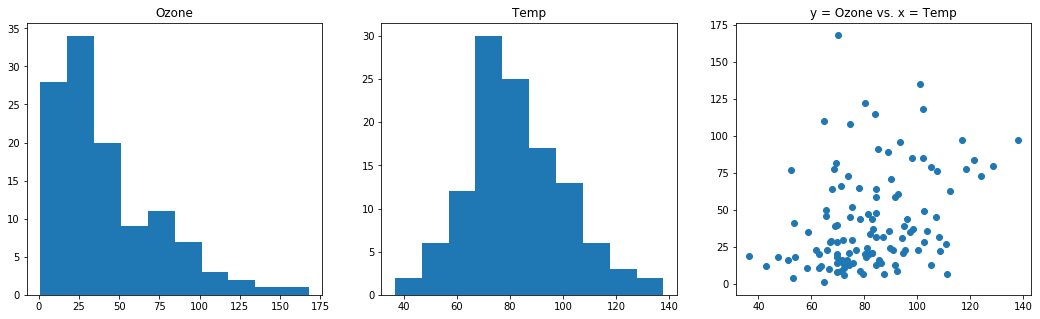

In [5]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize = (18,5))


ax1.hist(df['Ozone'])
ax1.set_title("Ozone")
ax2.hist(df['Temp'])
ax2.set_title("Temp")
ax3.scatter(df['Temp'],df['Ozone'])
ax3.set_title("y = Ozone vs. x = Temp")
plt.show()

## Part 1: Gradient Boosting Regression Trees

Below we start to build a boosted regression model by hand for you to predict `Ozone` from `Temp`:

In [6]:
# Fit a single decision tree stump 
basemodel = DecisionTreeRegressor(max_depth=1)
basemodel.fit(x, y)
y_pred = basemodel.predict(x)

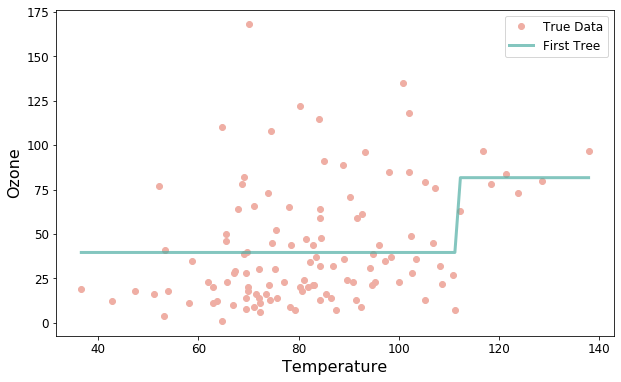

In [7]:
plt.figure(figsize=(10,6))
xrange = np.linspace(x.min(),x.max(),100)
plt.plot(x,y,'o',color='#EFAEA4', markersize=6, label="True Data")
# plt.plot([x.min(),x.max()],[0,0],'--')
plt.xlim()
plt.plot(x,y_pred,alpha=0.7,linewidth=3,color='#50AEA4', label='First Tree')
plt.xlabel("Temperature", fontsize=16)
plt.ylabel("Ozone", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='best',fontsize=12)
plt.show()

In [8]:
# calculate error residuals
residuals = y - y_pred

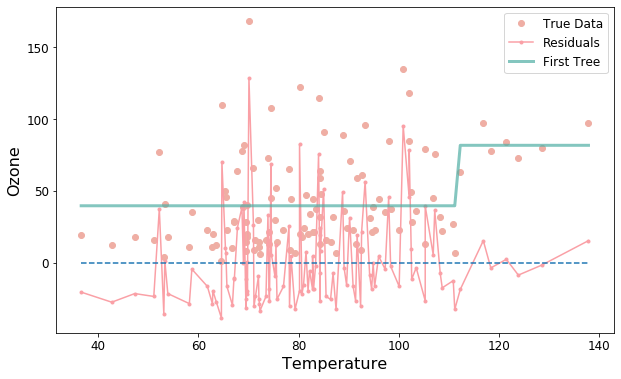

In [9]:
# add the residuals to the plot
plt.figure(figsize=(10,6))

plt.plot(x,y,'o',color='#EFAEA4', markersize=6, label="True Data")
plt.plot(x,residuals,'.-',color='#faa0a6', markersize=6, label="Residuals")
plt.plot([x.min(),x.max()],[0,0],'--')
plt.xlim()
plt.plot(x,y_pred,alpha=0.7,linewidth=3,color='#50AEA4', label='First Tree')
plt.ylabel("Ozone", fontsize=16)
plt.xlabel("Temperature", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='upper right',fontsize=12)
plt.show()

In [10]:
### edTest(test_fitted_residuals) ###
# fit another tree stump on the residuals
dtr = DecisionTreeRegressor(max_depth=1);
dtr.fit(x, residuals)

y_pred_residuals = dtr.predict(x)

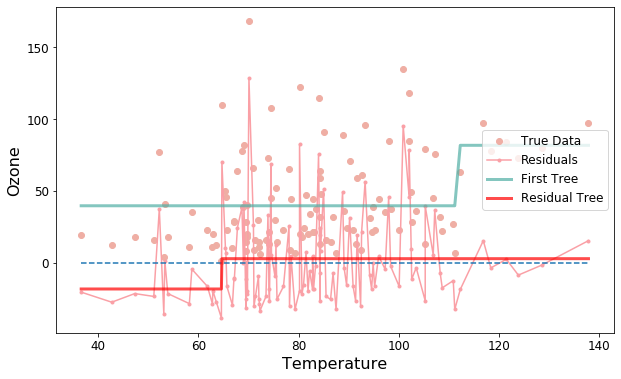

In [11]:
# add the fit of the residuals to the original plot 
plt.figure(figsize=(10,6))

plt.plot(x,y,'o',color='#EFAEA4', markersize=6, label="True Data")
plt.plot(x,residuals,'.-',color='#faa0a6', markersize=6, label="Residuals")
plt.plot([x.min(),x.max()],[0,0],'--')
plt.xlim()
plt.plot(x,y_pred,alpha=0.7,linewidth=3,color='#50AEA4', label='First Tree')
plt.plot(x,y_pred_residuals,alpha=0.7,linewidth=3,color='red', label='Residual Tree')
plt.ylabel("Ozone", fontsize=16)
plt.xlabel("Temperature", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='center right',fontsize=12)
plt.show()

In [12]:
lambda_ = 0.5
y_pred_new = y_pred + lambda_*y_pred_residuals

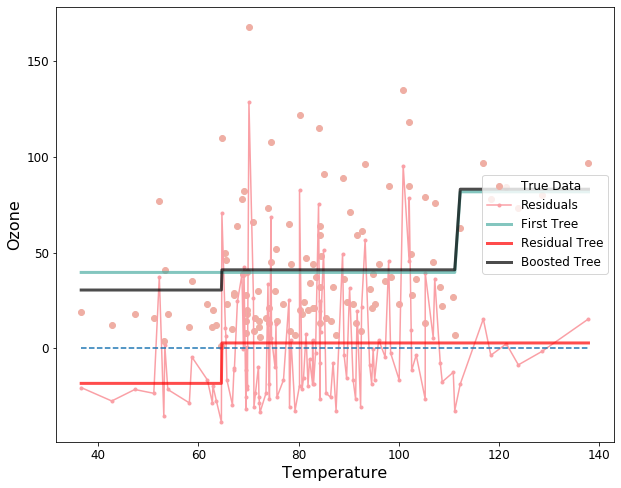

In [13]:
plt.figure(figsize=(10,8))

plt.plot(x,y,'o',color='#EFAEA4', markersize=6, label="True Data")
plt.plot(x,residuals,'.-',color='#faa0a6', markersize=6, label="Residuals")
plt.plot([x.min(),x.max()],[0,0],'--')
plt.xlim()
plt.plot(x,y_pred,alpha=0.7,linewidth=3,color='#50AEA4', label='First Tree')
plt.plot(x,y_pred_residuals,alpha=0.7,linewidth=3,color='red', label='Residual Tree')
plt.plot(x,y_pred_new,alpha=0.7,linewidth=3,color='k', label='Boosted Tree')
plt.ylabel("Ozone", fontsize=16)
plt.xlabel("Temperature", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='center right',fontsize=12)
plt.show()

**Q1.1** You can continue doing this! Try at least one more interation and play around with the lambda learning rate.  What happens as the iterations increase?  What happens as lambda changes?

*your answer here*

### Comparison with Bagging

To compare the two methods, we will be using sklearn's methods and not our own implementation from above. 

In [14]:
# Split the data into train and test sets with train size as 0.8 
# and random_state as 102
# The default value for shuffle is True for train_test_split, so the ordering we 
# did above is not a problem. 
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, random_state=109)

In [15]:
# Set a learning rate
l_rate = 0.01
num_trees = 1000

#  Boosting. We will use the sklearn's boosting model 
boosted_model  = GradientBoostingRegressor(n_estimators=num_trees,max_depth=1,learning_rate=l_rate )

boosted_model.fit(x_train,y_train)

y_pred = boosted_model.predict(x_test)

In [16]:
# train a bagging model
# Specify the number of bootstraps
num_bootstraps = 30

# Specify the maximum depth of the decision tree
max_depth = 100

# Define the Bagging Regressor Model
# Use Decision Tree as your base estimator with depth as mentioned in max_depth
# Initialise number of estimators using the num_bootstraps value
# Set max_samples as 0.8
bagging_model = BaggingRegressor(DecisionTreeRegressor(max_depth=max_depth),
                         n_estimators=num_bootstraps, max_samples=0.8,
                        random_state=3)
                        

# Fit the model on the entire data
bagging_model.fit(x_train, y_train)


# Predict on the test data
y_pred_bagging = bagging_model.predict(x_test)

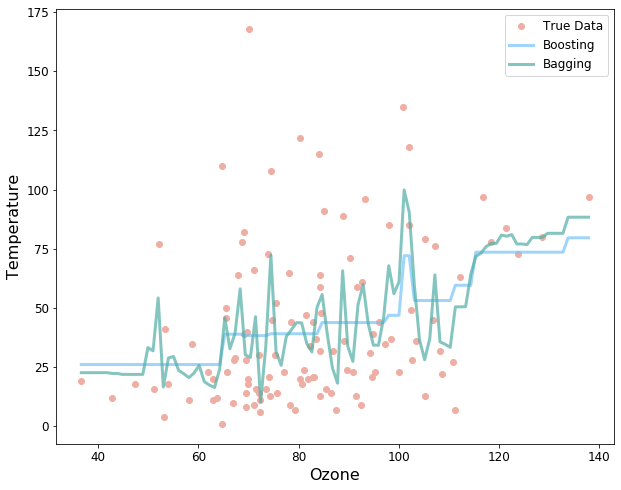

In [17]:
plt.figure(figsize=(10,8))

xrange = np.linspace(x.min(),x.max(),100).reshape(-1,1)
y_pred_boost = boosted_model.predict(xrange)
y_pred_bag = bagging_model.predict(xrange)
plt.plot(x,y,'o',color='#EFAEA4', markersize=6, label="True Data")
plt.xlim()
plt.plot(xrange,y_pred_boost,alpha=0.7,linewidth=3,color='#77c2fc', label='Boosting')
plt.plot(xrange,y_pred_bag,alpha=0.7,linewidth=3,color='#50AEA4', label='Bagging')
plt.xlabel("Ozone", fontsize=16)
plt.ylabel("Temperature", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='best',fontsize=12)
plt.show()

In [18]:
# Compute the MSE of the model prediction

print("The MSE of the Boosting model is",
    round(mean_squared_error(y_test,boosted_model.predict(x_test)),3))

The MSE of the Boosting model is 1351.229


In [19]:
# Compute the MSE of the model prediction

print("The MSE of the Bagging model is",
    round(mean_squared_error(y_test, y_pred_bagging),3))

The MSE of the Bagging model is 1750.405


**Q1.2** What do you notice here?  Why is this not a fair comparison?




*your answer here*

To be a more fair comparison, we should tune the hyper-parameters for both models. 

**Q1.3** Go back and play with the `learning rate`,`n_estimators` and `max_depth` for Boosting and `n_estimators` and `max_depth` for Bagging.  What do you notice?

*your answer here*

**Q1.4** How would RF compare? 

*your answer here*

You can plot the progression of the accuracy/error metric (MSE here) as a funciton of the numbor of trees using the `staged_predict` method for the model:

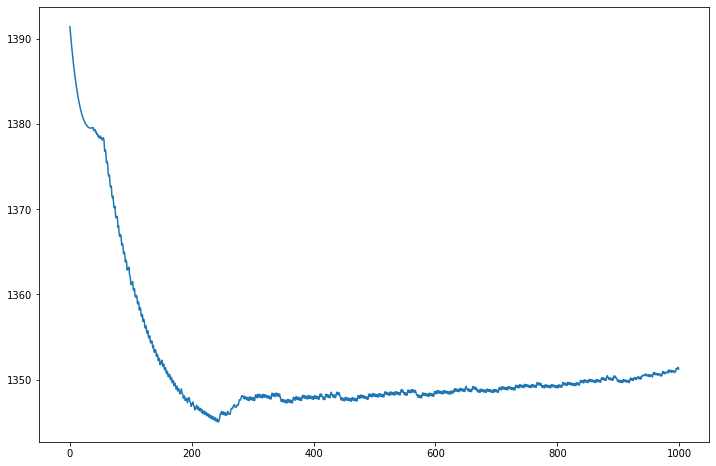

In [20]:
from sklearn.metrics import mean_squared_error
test_score = np.zeros((num_trees,), dtype=np.float64)

for i, y_pred in enumerate(boosted_model.staged_predict(x_test)):
    test_score[i] = mean_squared_error(y_test, y_pred)
    

plt.plot(test_score);

**Q1.5** What do you notice in the plot above?

*your answer here*

---

## Part 2: AdaBoost Classification

We have a synthetic toy dataset for the classification modeling:

In [21]:
# Read the dataset as a pandas dataframe
df = pd.read_csv("../data/boostingclassifier2.csv")

df.head()

,latitude,longitude,landtype
0,-0.070288,-1.143493,0
1,0.521946,-0.043497,1
2,-0.708091,-0.870615,0
3,0.729733,-0.045884,1
4,-1.760767,-1.789587,0


In [22]:

# Read the columns latitude and longitude as the predictor variables
X = df[['latitude','longitude']].values

# Landtype is the response variable
y = df['landtype'].values

print(df.shape)

X, X_test, y, y_test = train_test_split(X, y, train_size=0.5, random_state=109)

print(X.shape, X_test.shape)

(1091, 3)
(545, 2) (546, 2)


In [23]:
# helper plotting function
from matplotlib.colors import ListedColormap

def plot_decision_boundary(classifier, X, y, N = 10, scatter_weights = np.ones(len(y)) , 
                           ax = None,counter=0,label=False):
    '''Utility function to plot decision boundary and scatter plot of data'''
    x_min, x_max = X[:, 0].min() - .1, X[:, 0].max() + .1
    y_min, y_max = X[:, 1].min() - .1, X[:, 1].max() + .1
    xx, yy = np.meshgrid( np.linspace(x_min, x_max, N), np.linspace(y_min, y_max, N))
    cmap = ListedColormap(["#ABCCE3","#50AEA4"])
    
    #Check what methods are available
    if hasattr(classifier, "decision_function"):
        zz = np.array( [classifier.decision_function(np.array([xi,yi]).reshape(1,-1)) for  xi, yi in zip(np.ravel(xx), np.ravel(yy)) ] )
    elif hasattr(classifier, "predict_proba"):
        zz = np.array( [classifier.predict_proba(np.array([xi,yi]).reshape(1,-1))[:,1] for  xi, yi in zip(np.ravel(xx), np.ravel(yy)) ] )
    else :
        zz = np.array( [classifier(np.array([xi,yi]).reshape(1,-1)) for  xi, yi in zip(np.ravel(xx), np.ravel(yy)) ] )
            
    # reshape result and plot
    Z = zz.reshape(xx.shape)
    cm_bright = ListedColormap(["#EFAEA4","#F6345E"])
    
    #Get current axis and plot
    if ax is None:
        ax = plt.gca()
    ax.contourf(xx, yy, Z,cmap=cmap,alpha=0.4)
    if label:
        ax.scatter(X[:,0],X[:,1], c = y, cmap = cm_bright, s = scatter_weights * 40, edgecolors='k',label = f'Stump {counter}')
        ax.legend(fontsize=16)
    else:
        ax.scatter(X[:,0],X[:,1], c = y, cmap = cm_bright, s = scatter_weights * 40, edgecolors='k',label = f'Stump {counter}')
    ax.set_xlabel('$Latitude$', fontsize=14)
    ax.set_ylabel('$Longitude$', fontsize=14)
    ax.set_title(f'Stump {counter+1} decision boundary',fontsize=16)

    


In [24]:
# AdaBoost algorithm implementation from scratch

def AdaBoost_scratch(X,y, M=10, learning_rate = 1):
    #Initialization of utility variables
    N = len(y)
    estimator_list, y_predict_list, estimator_error_list, estimator_weight_list, sample_weight_list = [], [],[],[],[]

    #Initialize the sample weights
    sample_weight = np.ones(N) / N
    
    # Cooy the sample weights to another list
    sample_weight_list.append(sample_weight.copy())

    #For m = 1 to M where M is the number of stumps
    for m in range(M):   

        #Fit a Decision Tree classifier stump with a maximum of 2 leaf nodes
        estimator = DecisionTreeClassifier(max_depth = 1, max_leaf_nodes=2)
        
        # Fit the model on the entire data with the sample weight initialise before
        estimator.fit(X, y, sample_weight=sample_weight)
        
        # Predcit on the entire data
        y_predict = estimator.predict(X)

        # Compute the number of misclassifications
        incorrect = (y_predict != y)

        # Compute the error as the mean of the weighted sum of the number of incorrect predictions given the sample weight
        estimator_error = np.mean( np.average(incorrect, weights=sample_weight, axis=0))
        
        # Compute the new weights using the learning rate and estimator error
        estimator_weight =  learning_rate * np.log((1. - estimator_error) / estimator_error)

        # Boost the sample weights
        sample_weight *= np.exp(estimator_weight * incorrect * ((sample_weight > 0) | (estimator_weight < 0)))

        # Save the iteration values
        estimator_list.append(estimator)
        y_predict_list.append(y_predict.copy())
        estimator_error_list.append(estimator_error.copy())
        estimator_weight_list.append(estimator_weight.copy())
        sample_weight_list.append(sample_weight.copy())
        

    #Convert to np array for convenience   
    estimator_list = np.asarray(estimator_list)
    y_predict_list = np.asarray(y_predict_list)
    estimator_error_list = np.asarray(estimator_error_list)
    estimator_weight_list = np.asarray(estimator_weight_list)
    sample_weight_list = np.asarray(sample_weight_list)

    # Compute the predictions
    preds = (np.array([np.sign((y_predict_list[:,point] * estimator_weight_list).sum()) for point in range(N)]))
    
    # Return the model, estimated weights and sample weights
    return estimator_list, estimator_weight_list, sample_weight_list

In [25]:

# Call the AdaBoost function to perform boosting classification
estimator_list, estimator_weight_list, sample_weight_list  = AdaBoost_scratch(X, y, M = 6, learning_rate = 1)


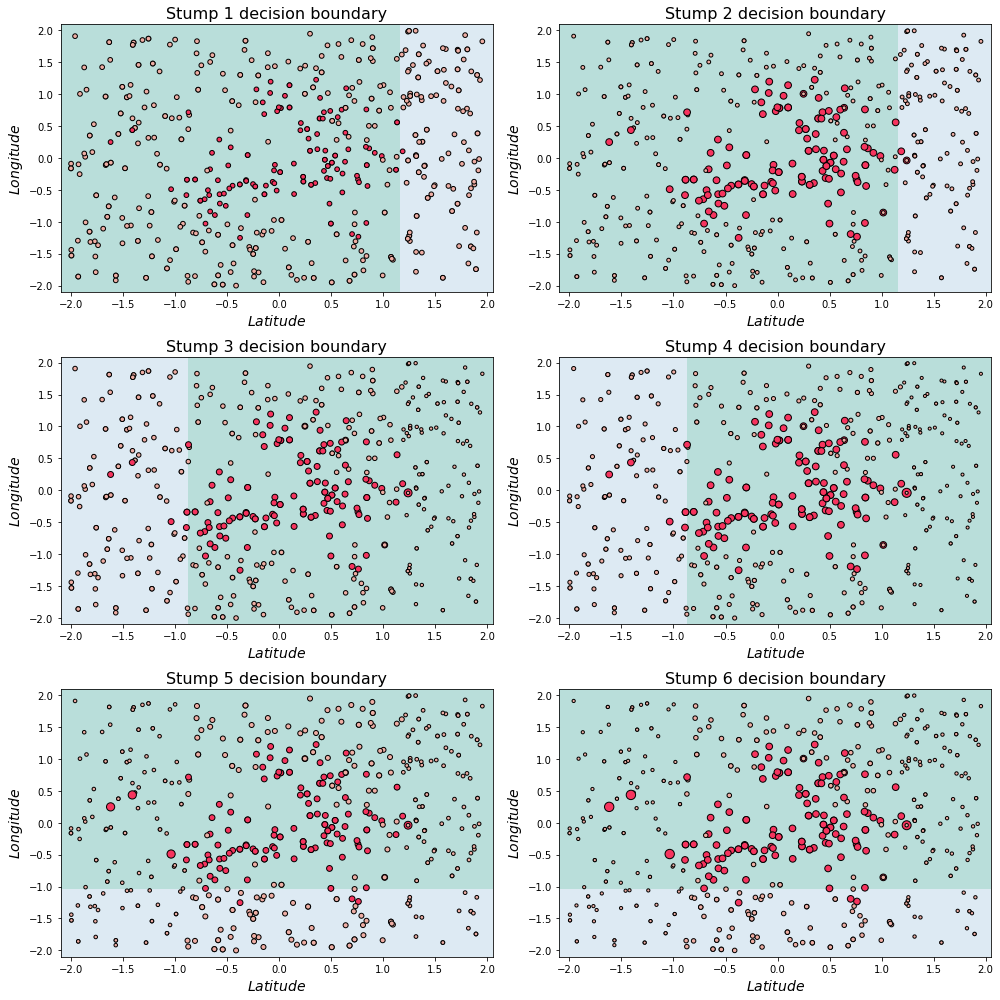

In [26]:
# Helper code to plot the AdaBoost Decision Boundary stumps
fig = plt.figure(figsize = (14,14))
for m in range(0,6):
    fig.add_subplot(3,2,m+1)

    s_weights = (sample_weight_list[m,:] / sample_weight_list[m,:].sum() ) * 300
    plot_decision_boundary(estimator_list[m], X,y,N = 50, scatter_weights =s_weights,counter=m)
    plt.tight_layout()

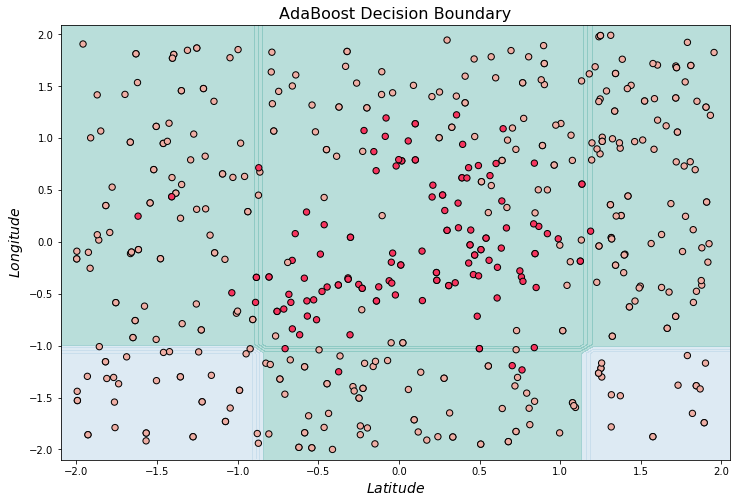

In [27]:
# Use sklearn's AdaBoostClassifier to take a look at the final decision boundary 

# Initialise the model with Decision Tree classifier as the base model same as above
# Use SAMME as the algorithm and 6 estimators with learning rate as 1
boost = AdaBoostClassifier( base_estimator = DecisionTreeClassifier(max_depth = 1, max_leaf_nodes=2), 
                            algorithm = 'SAMME', n_estimators=6, learning_rate=1.0)

# Fit on the entire data
boost.fit(X,y)

# Call the plot_decision_boundary function to plot the decision boundary of the model 
plot_decision_boundary(boost, X, y, N = 50)

plt.title('AdaBoost Decision Boundary', fontsize=16)
plt.show()


**Q2.1** Play around with the `learning_rate` and the `num_estimators` and see how it affects the boosted trees.  How did they compare?

*your answer here*

**Q2.2** Be a little more careful about evaluating the different choices of `learning_rate` and `num_estimators`: for `learning_rate [0.25,0.5,0.75,1]`, use the `list(staged_score)` ([link](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html#sklearn.ensemble.AdaBoostClassifier.staged_score)) method to compare the models accuracy on the test set.

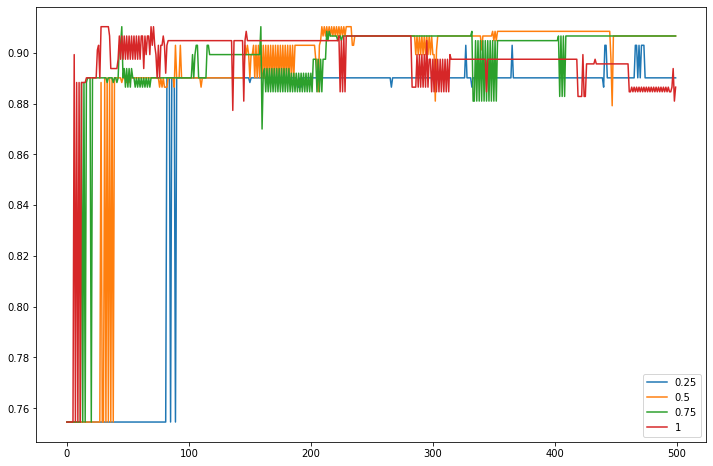

In [28]:
#########
# Your code here
#########

learns = [0.25,0.5,0.75,1]

for learn in learns:
    boost = AdaBoostClassifier( base_estimator = DecisionTreeClassifier(max_depth = 1, max_leaf_nodes=2), 
                            algorithm = 'SAMME', n_estimators=500, learning_rate=learn).fit(X,y)
    plt.plot(list(boost.staged_score(X_test,y_test)),label=learn)
    
plt.legend();





**Q2.3** Interpret the plot above.  What can you conclude from this toy example?

*your answer here*